[View in Colaboratory](https://colab.research.google.com/github/mogamin/dlllab-hackathon/blob/master/dllab_1st_hackathon_tutorial_image_classification1_with_cuda_1.ipynb)

In [43]:
!apt-get install -y -qq libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80==4.0.0b4 
!pip install chainer==4.0.0b4

In [25]:
import chainer

print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from chainer.datasets import get_mnist
train, test = get_mnist(ndim=3) # ndim=3はcnn用のデータセット形式

In [28]:
print(len(train))
print(len(test))

60000
10000


> このchainerのデータセット形式はリストのような形式になっており、各サンプルに（画像、ラベル）のようにタプル形式で格納されています。

* train[0]: １サンプル目の(画像、ラベル)が格納
* train[0][0]: １サンプル目の画像（float32）
* train[0][1]: １サンプル目のラベル（int32）



In [29]:
# image-data
print(type(train[0][0]))
print(train[0][0].shape)
print(train[0][0].dtype)

# image label
print(type(train[0][1]))
print(train[0][1].shape)
print(train[0][1].dtype)

<class 'numpy.ndarray'>
(1, 28, 28)
float32
<class 'numpy.int32'>
()
int32


In [30]:
# (channel,hight,width) -> (height,width,channel)
img = np.transpose(train[0][0], (1,2,0))
img.shape

(28, 28, 1)

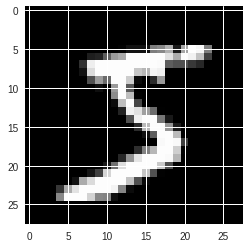

In [31]:
plt.gray()
plt.imshow(img.reshape(28,28))

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F

In [0]:
class CNN(chainer.Chain):
  
  def __init__(self, n_mid=100, n_out=10):
    super().__init__()
    with self.init_scope():
      self.conv1 = L.Convolution2D(in_channels=1, out_channels=3, ksize=3, stride=1, pad=1)
      self.fc1 = L.Linear(None, n_mid)
      self.fc2 = L.Linear(None, n_out)
  
  def __call__(self, x):
    h = F.relu(self.conv1(x))
    h = F.max_pooling_2d(h, 3, 3)
    h = self.fc1(h)
    h = self.fc2(h)
    return h

In [0]:
import random
def reset_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(seed)

In [35]:
reset_seed(0)
model = L.Classifier(CNN())

gpu_id = 0
model.to_gpu(gpu_id)

In [36]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [0]:
batchsize = 4096
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [38]:
from chainer import training
from chainer.training import extensions

epoch = 30
updater = training.StandardUpdater(train_iter,optimizer,device=gpu_id)
trainer = training.Trainer(updater, (epoch, 'epoch'), out='mnist')

trainer.extend(extensions.Evaluator(test_iter,model,device=gpu_id))
trainer.extend(extensions.LogReport(trigger=(1,'epoch')))
trainer.extend(extensions.PrintReport(['epoch','main/accuracy','validation/main/accuracy','main/loss','validation/main/loss','elapsed_time']),trigger=(1,'epoch'))
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.39738        0.722084                  1.92332     1.32812               0.695213      
2           0.762435       0.823388                  1.05503     0.766939              1.25484       
3           0.829136       0.862845                  0.68892     0.55474               1.77748       
4           0.857129       0.881255                  0.534908    0.450401              2.33803       
5           0.87321        0.89231                   0.453907    0.394012              2.89616       
6           0.882795       0.898857                  0.408648    0.359427              3.42391       
7           0.890365       0.903767                  0.377311    0.333144              3.98322       
8           0.89611        0.909576                  0.355105    0.31362               4.54187       
9           0.901193       0.914464                  0.334722    0.299507           

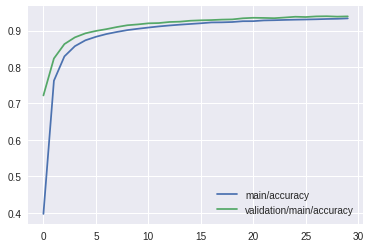

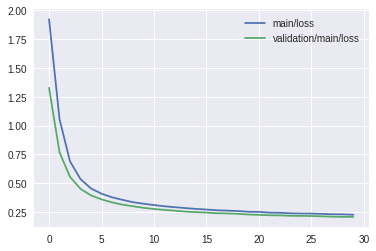

In [39]:
import json
import pandas as pd

with open('mnist/log') as f:
  result = pd.DataFrame(json.load(f))

result[['main/accuracy','validation/main/accuracy']].plot()
result[['main/loss','validation/main/loss']].plot()

In [40]:
# モデルをCPUに転送
model.to_cpu()

In [0]:
chainer.serializers.save_npz('model_mnist.npz',model)

In [42]:
!ls -l
!head model_mnist.npz

total 124
drwxr-xr-x 3 root root   4096 Aug  1 18:45 datalab
drwxr-xr-x 2 root root   4096 Aug  3 04:16 mnist
-rw-r--r-- 1 root root 116929 Aug  3 04:16 model_mnist.npz
�<�yk���i��j���Z��Z[�B���x��������~S��۽��޵�/�U5X�x���Q���#j������>��o�2����>=F��1�ۺ�I�g��E�I���-�~�Z .ѧ��1~pѼU�$�1\�S�>B�X:'*�� ʦ���,xe"CKk��n/t1�4Od�o؈��%�K�#�]�Aga�Z��mh�ƂɼF����-b�HV��S�A� F���h�>˿v�K<��;p��4`�L5ܸt�>�<I�}'ߏ▌0�Z^C�O��Ę�vw3|�>&6��m��K����LHu$��I�Mѐ��@��
�����M
$�h�i��&�*n�"��P�
���k�lx8[
mL�G\�?�[��t2��[F$ԓ��x�=�7Z��]�c�slc�!el/h�2ÎG2�Q
�D�^� $_^ϔ�->}Pt-t�'���]�z�n��2G��ߤ)������<4�y��#�I޺��/�,�B[��ލ�Ɨ1���%�������7m!3���9w;:�Ӹ���9|��:�
GjD�bq�GP��:�ߟ{2�L�Ѣ����1�
��<r|w���&h���������RX'���nQ~�|�/,�xL��Z+!�5=G~u�f�����(`�����.U4�9z����p8���ߟ�W�Ɖnm �֤|_�Pb"�s�;���� ���yf\�-`ʮ�i�/��!K� �CѼ1������B}UǢ���Z��ꋔݱ�%���׋pu �f�b��,���RػM�ʇ���� @���
�.x3�`^w����2|�]��.ǍjV�q�=�h܈�xӰ�� �N�I5��HO�ҩLdN��[��Q�5n��	��